In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

from modules.smoothed_target_encoder import SmoothedTargetEncoder
from modules.cyclical_encoder import CyclicalEncoder

In [2]:
df_flights = pd.read_csv("./data/flights.csv", low_memory=False)

# Set the columns to lower case
df_flights.columns = df_flights.columns.str.lower()
df_flights = df_flights.fillna(0)
df_flights['is_delayed'] = (df_flights['arrival_delay'] > 15).astype(int)

In [3]:
df_flights.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,is_delayed
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,-22.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,5.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,-21.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
#variable that we know before the flight 
known_variables = [
    'month', 'day', 'day_of_week', 
    'airline', 'origin_airport', 'destination_airport', 
    'scheduled_departure', 'scheduled_time', 
    'elapsed_time', 'air_time', 
    'distance', 'scheduled_arrival',
    'is_delayed'
]
df_features = df_flights[known_variables].copy()

In [5]:
df_features.head()

,month,day,day_of_week,airline,origin_airport,destination_airport,scheduled_departure,scheduled_time,elapsed_time,air_time,distance,scheduled_arrival,is_delayed
0,1,1,4,AS,ANC,SEA,5,205.0,194.0,169.0,1448,430,0
1,1,1,4,AA,LAX,PBI,10,280.0,279.0,263.0,2330,750,0
2,1,1,4,US,SFO,CLT,20,286.0,293.0,266.0,2296,806,0
3,1,1,4,AA,LAX,MIA,20,285.0,281.0,258.0,2342,805,0
4,1,1,4,AS,SEA,ANC,25,235.0,215.0,199.0,1448,320,0


In [6]:
df_features['route'] = df_features['origin_airport'] + '_' + df_features['destination_airport']

In [7]:
# enc_origin = SmoothedTargetEncoder('origin_airport', 'is_delayed')
# enc_destination = SmoothedTargetEncoder('destination_airport', 'is_delayed')
enc_route = SmoothedTargetEncoder('route', 'is_delayed')
enc_airline = SmoothedTargetEncoder('airline', 'is_delayed')

In [8]:
# df_features['origin_airport_encoded'] = enc_origin.fit_transform(df_features)
# df_features['destination_airport_encoded'] = enc_destination.fit_transform(df_features)
df_features['route_encoded'] = enc_route.fit_transform(df_features)
df_features['airline_encoded'] = enc_airline.fit_transform(df_features)

In [9]:
cyclical_features = {
    'month': 12,
    'day_of_week': 7,
    'scheduled_departure': 1440
}

for feature, period in cyclical_features.items():
    enc = CyclicalEncoder(feature, period)
    df_features = enc.fit_transform(df_features)


In [10]:
final_features = [
    'distance', 
#     'origin_airport_encoded', 'destination_airport_encoded', 
    'route_encoded', 'airline_encoded',
    'month_sin', 'month_cos', 
    'day_of_week_sin', 'day_of_week_cos', 
    'scheduled_departure_sin', 'scheduled_departure_cos',
    'day',
    'is_delayed'
]

df_processed = df_features[final_features].copy()

In [11]:
df_processed.head()

,distance,route_encoded,airline_encoded,month_sin,month_cos,day_of_week_sin,day_of_week_cos,scheduled_departure_sin,scheduled_departure_cos,day,is_delayed
0,1448,0.101697,0.122971,0.5,0.866025,-0.433884,-0.900969,0.021815,0.999762,1,0
1,2330,0.293107,0.172742,0.5,0.866025,-0.433884,-0.900969,0.043619,0.999048,1,0
2,2296,0.118210,0.175863,0.5,0.866025,-0.433884,-0.900969,0.087156,0.996195,1,0
3,2342,0.202588,0.172308,0.5,0.866025,-0.433884,-0.900969,0.087156,0.996195,1,0
4,1448,0.170145,0.123137,0.5,0.866025,-0.433884,-0.900969,0.108867,0.994056,1,0


In [29]:
df_processed['is_delayed'].value_counts(normalize=True)


0    0.824113
1    0.175887
Name: is_delayed, dtype: float64

In [12]:
df_processed.corr()

,distance,route_encoded,airline_encoded,month_sin,month_cos,day_of_week_sin,day_of_week_cos,scheduled_departure_sin,scheduled_departure_cos,day,is_delayed
distance,1.000000,0.054811,0.012067,-0.008894,-0.009932,-0.013229,0.013769,-0.040209,-0.034200,0.003529,0.007257
route_encoded,0.054811,1.000000,0.331021,0.127415,-0.067586,0.009405,0.002740,0.017885,0.006460,-0.001768,0.126613
airline_encoded,0.012067,0.331021,1.000000,0.009760,0.005695,-0.002731,0.002379,0.017396,-0.012507,0.000270,0.080618
month_sin,-0.008894,0.127415,0.009760,1.000000,-0.001213,-0.001292,-0.001092,0.001418,0.005109,-0.009105,0.041562
month_cos,-0.009932,-0.067586,0.005695,-0.001213,1.000000,-0.001157,-0.003095,-0.005952,0.014112,-0.009767,-0.020181
day_of_week_sin,-0.013229,0.009405,-0.002731,-0.001292,-0.001157,1.000000,0.032103,0.009553,-0.002948,-0.005523,0.003602
day_of_week_cos,0.013769,0.002740,0.002379,-0.001092,-0.003095,0.032103,1.000000,-0.007059,0.010033,0.012275,-0.010416
scheduled_departure_sin,-0.040209,0.017885,0.017396,0.001418,-0.005952,0.009553,-0.007059,1.000000,-0.023952,-0.001211,0.069934
scheduled_departure_cos,-0.034200,0.006460,-0.012507,0.005109,0.014112,-0.002948,0.010033,-0.023952,1.000000,-0.001579,0.052815
day,0.003529,-0.001768,0.000270,-0.009105,-0.009767,-0.005523,0.012275,-0.001211,-0.001579,1.000000,-0.007485


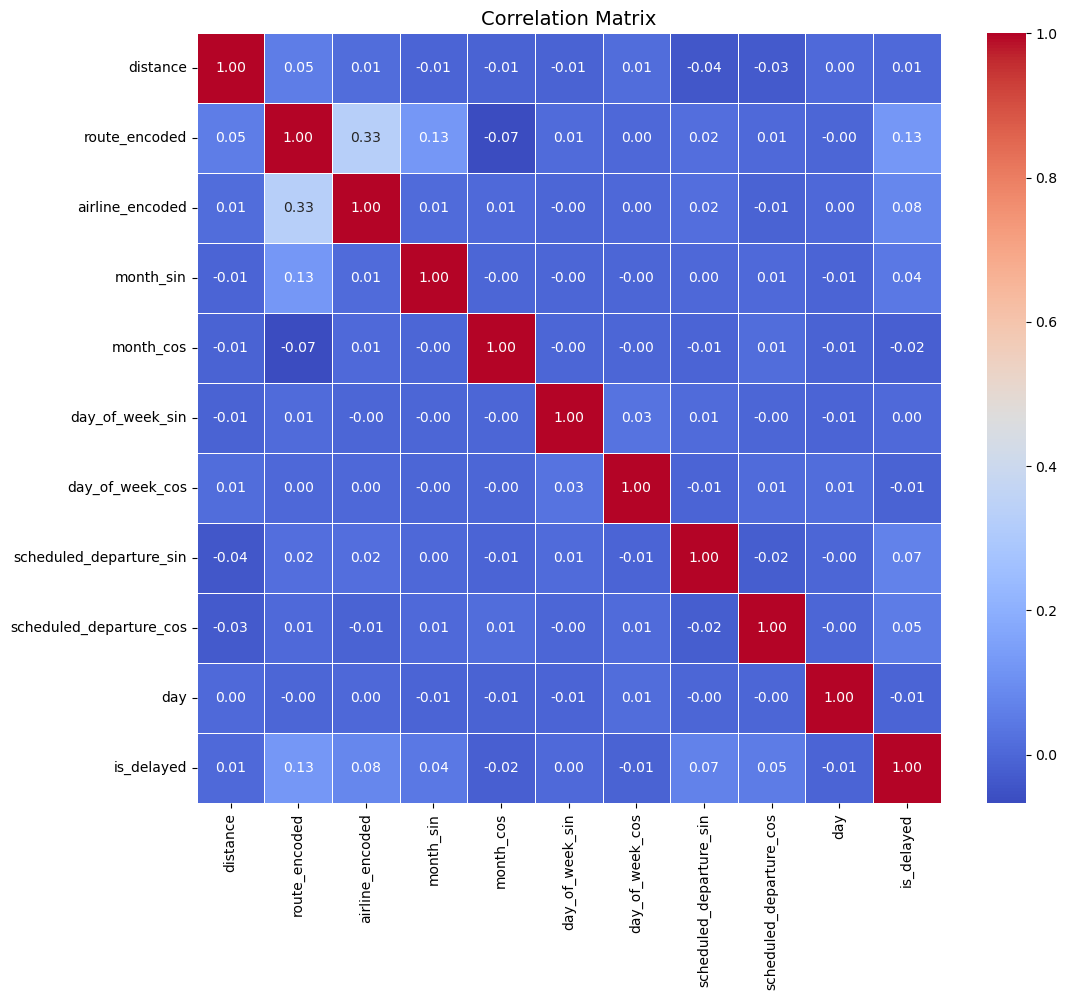

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df_processed.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

In [14]:
X = df_processed.drop(columns=['is_delayed'])
y = df_processed['is_delayed']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
feature_names = X_train.columns.tolist()
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

In [40]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss', 
    scale_pos_weight=2,
    n_estimators=1000,
    learning_rate=0.01,
    subsample=0.6,
    max_depth=5,
    random_state=42
)

In [41]:
xgb_model.fit(X_train_scaled_df, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [42]:
# Predict probabilities for AUC calculation
y_pred_proba = xgb_model.predict_proba(X_test_scaled_df)[:, 1]

# Predict class labels
y_pred = xgb_model.predict(X_test_scaled_df)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

print("\n### Model Evaluation Results (Test Set) ###")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {auc_score:.4f}")
print("\nConfusion Matrix:")
print(cm)


### Model Evaluation Results (Test Set) ###
Accuracy: 0.8188
ROC-AUC Score: 0.6847

Confusion Matrix:
[[929239  29877]
 [181002  23698]]


In [24]:
lgb_model = lgb.LGBMClassifier(
    objective='binary',          # Binary classification
    metric='auc',                # Evaluate performance using AUC
    n_estimators=100,            # Number of boosting rounds
    learning_rate=0.1,
    num_leaves=31,               # Max number of leaves in one tree (default)
    max_depth=-1,                # No limit on tree depth
    random_state=42,
    n_jobs=-1                    # Use all available cores for faster training
)

In [25]:
lgb_model.fit(X_train_scaled_df, y_train)

[LightGBM] [Info] Number of positive: 818798, number of negative: 3836465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 4655263, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175887 -> initscore=-1.544469
[LightGBM] [Info] Start training from score -1.544469


LGBMClassifier(metric='auc', n_jobs=-1, objective='binary', random_state=42)

In [26]:
# Predict probabilities (needed for ROC-AUC)
y_pred_proba = lgb_model.predict_proba(X_test_scaled_df)[:, 1]

# Predict class labels
y_pred = lgb_model.predict(X_test_scaled_df)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

print("\n### LightGBM Model Evaluation Results (Test Set) ###")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {auc_score:.4f}")
print("\nConfusion Matrix:")
print(cm)


### LightGBM Model Evaluation Results (Test Set) ###
Accuracy: 0.8250
ROC-AUC Score: 0.6948

Confusion Matrix:
[[957661   1455]
 [202173   2527]]
